## The problem

- Walking around in a 2D maze
- This is a toy problem, we will make it more challenging later

In [127]:
import gym
import numpy as np
import ray
from ray.rllib.agents.dqn import DQNTrainer
from ray.rllib.agents.ppo import PPOTrainer
from ray.rllib.models.preprocessors import get_preprocessor 
from tqdm.notebook import trange, tqdm
import matplotlib.pyplot as plt
import copy

In [2]:
# import tensorflow as tf
import tensorflow.compat.v1 as tf

In [3]:
tf.__version__

'2.8.0'

In [4]:
ray.init(ignore_reinit_error=True)

{'node_ip_address': '127.0.0.1',
 'raylet_ip_address': '127.0.0.1',
 'redis_address': '127.0.0.1:6379',
 'object_store_address': '/tmp/ray/session_2022-03-28_15-51-11_553544_66453/sockets/plasma_store',
 'raylet_socket_name': '/tmp/ray/session_2022-03-28_15-51-11_553544_66453/sockets/raylet',
 'webui_url': None,
 'session_dir': '/tmp/ray/session_2022-03-28_15-51-11_553544_66453',
 'metrics_export_port': 57285,
 'gcs_address': '127.0.0.1:54831',
 'node_id': '4bfe56ec94e67d790ae0c7bcb4d34bd0c31154961b9c63e8d72e401d'}

In [5]:
action_names = {
    0 : "up",
    1 : "down",
    2 : "right",
    3 : "left"
}

In [6]:
class MazeEnvironment(gym.Env): 
    def __init__(self, env_config):
        self.ylen = env_config.get("ylen", 5)
        self.xlen = env_config.get("xlen", 5)
        
        self.action_space = gym.spaces.Discrete(4)
        self.observation_space = gym.spaces.Discrete(self.ylen*self.xlen)
    
    def reset(self, seed=42):
        self.player = (0, 0)
        self.exit = (self.ylen-1, self.xlen-1)
        if seed is not None:
            np.random.seed(seed)
        self.walls = np.random.rand(self.ylen, self.xlen) < 0.2
        self.walls[self.player] = 0
        self.walls[self.exit] = 0
        self.num_steps = 0
        return self.get_observation()
    
    def get_observation(self):
        return self.player[0] + self.ylen*self.player[1] # TODO: FIX TO MATCH THE ONE BELOW SO IT GOES ROWS FIRST
    
    def step(self, action):
        self.num_steps += 1
        
        if action == 0: # move up
            new_loc = (self.player[0]-1, self.player[1])
            if new_loc[0] > 0 and not self.walls[new_loc]:
                self.player = new_loc
        
        elif action == 1: # move down
            new_loc = (self.player[0]+1, self.player[1])
            if new_loc[0] < self.ylen and not self.walls[new_loc]:
                self.player = new_loc
                
        elif action == 2: # move right
            new_loc = (self.player[0], self.player[1]+1)
            if new_loc[1] < self.xlen and not self.walls[new_loc]:
                self.player = new_loc
                
        elif action == 3: # move left
            new_loc = (self.player[0], self.player[1]-1)
            if new_loc[1] > 0 and not self.walls[new_loc]:
                self.player = new_loc
                
        else:
            raise Exception("Action must be {0,1,2,3}")
                
        info = {"player pos" : self.player}
        
        return self.get_observation(), self.get_reward(), self.is_done(), info


    def get_reward(self):
        # return self.player == self.exit
        dist = np.abs(self.player[0]-self.exit[0]) + np.abs(self.player[1]-self.exit[1])
        return -dist
    
    def is_done(self):
        return self.player == self.exit or self.num_steps >= 500

    def render(self):
        for i in range(self.xlen):
            for j in range(self.ylen):
                if (i,j) == self.exit:
                    print("E", end="")
                elif (i,j) == self.player:
                    print("P", end="")
                elif self.walls[i,j]:
                    print("X", end="")
                else:
                    print(".", end="")
                # print("O", end="")
            print()

In [7]:
# BY DEFAULT USES SEED 22
me = MazeEnvironment({})
me.reset()
me.render()

P...X
XX...
X...X
X....
.X..E


In [8]:
# sorted(trainer.config)

In [9]:
trainer_config = {
    "num_workers": 1,
    # "model": {
    #     "fcnet_hiddens": [64, 64],
    #     "fcnet_activation": "relu",
    # },
    "evaluation_num_workers": 1,
    # "evaluation_interval" : 1,
    "create_env_on_driver" : True,
    # "evaluation_config": {
    #     "render_env": True,
    # },
    "log_level" : "ERROR"
    # "framework" : "torch" # default is tf
}

trainer = DQNTrainer(trainer_config, env=MazeEnvironment)

2022-03-28 15:51:14,175	INFO trainer.py:2054 -- Your framework setting is 'tf', meaning you are using static-graph mode. Set framework='tf2' to enable eager execution with tf2.x. You may also then want to set eager_tracing=True in order to reach similar execution speed as with static-graph mode.
2022-03-28 15:51:14,178	WARNING trainer.py:2279 -- You have specified 1 evaluation workers, but your `evaluation_interval` is None! Therefore, evaluation will not occur automatically with each call to `Trainer.train()`. Instead, you will have to call `Trainer.evaluate()` manually in order to trigger an evaluation run.
2022-03-28 15:51:14,178	INFO simple_q.py:153 -- In multi-agent mode, policies will be optimized sequentially by the multi-GPU optimizer. Consider setting `simple_optimizer=True` if this doesn't work for you.
2022-03-28 15:51:14,178	INFO trainer.py:790 -- Current log_level is ERROR. For more information, set 'log_level': 'INFO' / 'DEBUG' or use the -v and -vv flags.


In [10]:
rewards = []
for episode in range(10):
    print(episode)
    out = trainer.train();
    rewards.append(out['episode_reward_mean'])

0
1
2
3
4
5
6
7
8
9


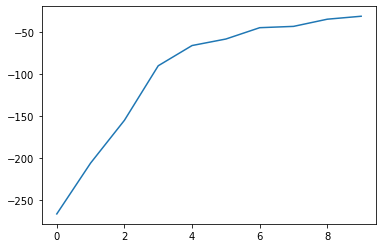

In [11]:
plt.plot(rewards);

In [12]:
out;

In [13]:
me = MazeEnvironment({})
obs = me.reset() # BY DEFAULT USES SEED 22
me.render()

P...X
XX...
X...X
X....
.X..E


In [14]:
action = trainer.compute_single_action(input_dict={"obs": obs}, explore=False)
res = me.step(action)
obs = res[0]
me.render()

print("\naction:", action_names[action])
print("reward:", res[1])
print("done:", res[2])

.P..X
XX...
X...X
X....
.X..E

action: right
reward: -7
done: False


try with a fresh trainer to make sure it does badly:

In [15]:
new_trainer = DQNTrainer(trainer_config, env=MazeEnvironment)
me = MazeEnvironment({})
obs = me.reset() 
me.render()

P...X
XX...
X...X
X....
.X..E


In [16]:
action = new_trainer.compute_single_action(input_dict={"obs": obs}, explore=False)
res = me.step(action)
obs = res[0]
me.render()

P...X
XX...
X...X
X....
.X..E


back to orig trainer:

In [17]:
trainer.config["evaluation_config"]["explore"]

False

In [18]:
trainer.evaluate()

{'evaluation': {'episode_reward_max': -28.0,
  'episode_reward_min': -28.0,
  'episode_reward_mean': -28.0,
  'episode_len_mean': 8.0,
  'episode_media': {},
  'episodes_this_iter': 10,
  'policy_reward_min': {},
  'policy_reward_max': {},
  'policy_reward_mean': {},
  'custom_metrics': {},
  'hist_stats': {'episode_reward': [-28.0,
    -28.0,
    -28.0,
    -28.0,
    -28.0,
    -28.0,
    -28.0,
    -28.0,
    -28.0,
    -28.0],
   'episode_lengths': [8, 8, 8, 8, 8, 8, 8, 8, 8, 8]},
  'sampler_perf': {'mean_raw_obs_processing_ms': 0.11215092223367576,
   'mean_inference_ms': 0.5460697927592711,
   'mean_action_processing_ms': 0.022567348715699754,
   'mean_env_wait_ms': 0.02047750684950087,
   'mean_env_render_ms': 0.0},
  'off_policy_estimator': {},
  'timesteps_this_iter': 0}}

In [19]:
policy = trainer.get_policy()
model = policy.model

In [20]:
obs_space = me.observation_space
preprocessor = get_preprocessor(obs_space)(obs_space)
observations = me.reset()
transformed = preprocessor.transform(observations).reshape(1, -1)

In [21]:
transformed

array([[1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0.]], dtype=float32)

In [22]:
model_output, _ = model({"obs": transformed})

In [23]:
model_output

<tf.Tensor 'model/fc_out/Tanh:0' shape=(1, 256) dtype=float32>

In [24]:
q_values = model.get_q_value_distributions(model_output)

In [25]:
sess = policy.get_session()

In [26]:
model.base_model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 observations (InputLayer)      [(None, 25)]         0           []                               
                                                                                                  
 fc_1 (Dense)                   (None, 256)          6656        ['observations[0][0]']           
                                                                                                  
 fc_out (Dense)                 (None, 256)          65792       ['fc_1[0][0]']                   
                                                                                                  
 value_out (Dense)              (None, 1)            257         ['fc_1[0][0]']                   
                                                                                              

In [27]:
q_values

[<tf.Tensor 'BiasAdd_1:0' shape=(1, 4) dtype=float32>,
 <tf.Tensor 'default_policy/ExpandDims_10:0' shape=(1, 4, 1) dtype=float32>,
 <tf.Tensor 'default_policy/ExpandDims_1_1:0' shape=(1, 4, 1) dtype=float32>]

In [28]:
sess.run(q_values[0])

array([[-2.3872602, -2.284685 ,  5.4627037, -2.326112 ]], dtype=float32)

In [29]:
sess.run(q_values[1])

array([[[1.],
        [1.],
        [1.],
        [1.]]], dtype=float32)

In [30]:
sess.run(q_values[2])

array([[[1.],
        [1.],
        [1.],
        [1.]]], dtype=float32)

In [31]:
ac = trainer.compute_single_action(input_dict={"obs": observations}, explore=False)
ac

2

In [32]:
action_names[ac]

'right'

In [33]:
action_distribution = policy.dist_class(model_output, model) 
sample = action_distribution.sample()
sess.run(sample)

array([62])

## Random maze

Now we try to see what happens if the maze isn't the same every time

In [88]:
class RandomMazeEnvironment(gym.Env): 
    def __init__(self, env_config):
        self.ylen = env_config.get("ylen", 5)
        self.xlen = env_config.get("xlen", 5)
        
        self.action_space = gym.spaces.Discrete(4)
        
        # show entire state, not just nearby the player
        # self.observation_space = gym.spaces.Dict({
        #     "player" : gym.spaces.Discrete(self.ylen*self.xlen),
        #     "walls" : gym.spaces.MultiBinary(self.ylen*self.xlen)
        # })
        # self.observation_space = gym.spaces.MultiBinary([2, self.ylen, self.xlen])

        # see https://docs.ray.io/en/latest/rllib/rllib-models.html
        # looks like they mainly just preprocess discrete/multidiscrete and atari?
        # what about box?? hmm. i guess those go without preproc?
        
        # self.observation_space = gym.spaces.MultiDiscrete([2]*8)
        self.observation_space = gym.spaces.MultiBinary(8)
        # see the 8 spots around you
        # the 3 is for "nothing, wall, exit" as the 3 options
        
        self.seed = env_config.get("random_seed", None)
    
    def reset(self, seed=None):
        self.player = (0, 0)
        self.exit = (self.ylen-1, self.xlen-1)
        
        if self.seed is not None: # fixed seed every time, not random maze
            np.random.seed(self.seed)
        
        self.walls = np.random.rand(self.ylen, self.xlen) < 0.2
        self.walls[self.player] = 0
        self.walls[self.exit] = 0
        
        self.num_steps = 0
        return self.get_observation()
    
    def get_observation(self): # SWAPPED FROM THE ABOVE ONE
        # make the observation into the entire state??
        # playerstate = self.player[1] + self.xlen*self.player[0]
        # obsdict = {
        #     "player" : playerstate,
        #     "walls" : self.wallsstate
        # }
        # return obsdict
        
        # playerstate = 0*self.walls
        # playerstate[self.player] = 1
        # return np.concatenate((playerstate[None], 
        #                        self.walls[None]), axis=0).astype(int)
        
        # 3x3 context, 8 observations
        wallsexit = self.walls.copy()
        # wallsexit[self.exit] = 2 # does not work because type is bool, would need to fix type issue
        wallspad = np.pad(wallsexit, 1, constant_values=1) # pad with 1 to simulate walls all around
        nearby = wallspad[self.player[0]:self.player[0]+3, self.player[1]:self.player[1]+3]
        nearbyflat = nearby.flatten()
        minus_middle = np.concatenate((nearbyflat[:4], nearbyflat[5:]))
        return minus_middle
        # NW N NE W E SW S SE
    
    def step(self, action):
        self.num_steps += 1
        
        if action == 0: # move up
            new_loc = (self.player[0]-1, self.player[1])
            if new_loc[0] > 0 and not self.walls[new_loc]:
                self.player = new_loc
        
        elif action == 1: # move down
            new_loc = (self.player[0]+1, self.player[1])
            if new_loc[0] < self.ylen and not self.walls[new_loc]:
                self.player = new_loc
                
        elif action == 2: # move right
            new_loc = (self.player[0], self.player[1]+1)
            if new_loc[1] < self.xlen and not self.walls[new_loc]:
                self.player = new_loc
                
        elif action == 3: # move left
            new_loc = (self.player[0], self.player[1]-1)
            if new_loc[1] > 0 and not self.walls[new_loc]:
                self.player = new_loc
                
        else:
            raise Exception("Action must be {0,1,2,3}")
                
        info = {"player pos" : self.player}
        
        return self.get_observation(), self.get_reward(), self.is_done(), info


    def get_reward(self):
        # return self.player == self.exit
        dist = np.abs(self.player[0]-self.exit[0]) + np.abs(self.player[1]-self.exit[1])
        return -dist
    
    def is_done(self):
        return self.player == self.exit or self.num_steps >= 500

    def render(self):
        for i in range(self.xlen):
            for j in range(self.ylen):
                if (i,j) == self.exit:
                    print("E", end="")
                elif (i,j) == self.player:
                    print("P", end="")
                elif self.walls[i,j]:
                    print("X", end="")
                else:
                    print(".", end="")
                # print("O", end="")
            print()

In [89]:
rme = RandomMazeEnvironment({})

In [90]:
rme.reset()

array([ True,  True,  True,  True,  True,  True,  True, False])

In [91]:
rme.render()

PX..X
X...X
X....
..XX.
....E


In [129]:
trainer_config_2 = copy.copy(trainer_config)
trainer_config_2["model"] = {"fcnet_hiddens" : [64, 64]}

In [130]:
rme_dqn_trainer = DQNTrainer(trainer_config_2, env=RandomMazeEnvironment)

In [131]:
rme_dqn_rewards = []
for episode in range(10):
    print(episode)
    out = rme_dqn_trainer.train();
    rme_dqn_rewards.append(out['episode_reward_mean'])

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19


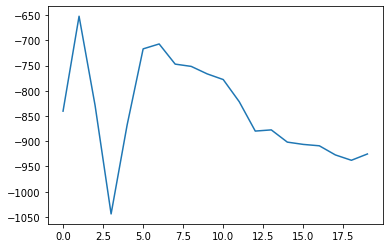

In [133]:
plt.plot(rme_dqn_rewards);

In [313]:
rme = RandomMazeEnvironment({})
obs = rme.reset() 
rme.render()

P....
.....
XXX..
....X
..X.E


In [362]:
action = rme_dqn_trainer.compute_single_action(input_dict={"obs": obs}, explore=False)
res = rme.step(action)
obs = res[0]
rme.render()

print("\naction:", action_names[action])
print("reward:", res[1])
print("done:", res[2])

.....
.....
XXX.P
....X
..X.E

action: down
reward: -2
done: False


In [337]:
policy = rme_dqn_trainer.get_policy()
model = policy.model

In [338]:
model_output = model({"obs": obs})[0]

In [339]:
q_values = model.get_q_value_distributions(model_output)

In [340]:
q_values

[<tf.Tensor 'BiasAdd_13:0' shape=(1, 4) dtype=float32>,
 <tf.Tensor 'default_policy/ExpandDims_16:0' shape=(1, 4, 1) dtype=float32>,
 <tf.Tensor 'default_policy/ExpandDims_1_7:0' shape=(1, 4, 1) dtype=float32>]

In [341]:
sess = policy.get_session()

In [342]:
sess.run(q_values[0])

array([[ 0.502599  ,  0.736714  ,  0.63609797, -2.4802601 ]],
      dtype=float32)

In [343]:
sess.run(q_values[1])

array([[[1.],
        [1.],
        [1.],
        [1.]]], dtype=float32)

In [344]:
sess.run(q_values[2])

array([[[1.],
        [1.],
        [1.],
        [1.]]], dtype=float32)

In [117]:
# rme_dqn_trainer.get_policy().model.base_model.summary()

AttributeError: 'ComplexInputNetwork_as_DistributionalQTFModel' object has no attribute 'base_model'

In [126]:
list(rme_dqn_trainer.get_policy().get_weights().values())[0].shape

(8, 256)

In [144]:
rme_dqn_trainer.evaluate()

{'evaluation': {'episode_reward_max': -28.0,
  'episode_reward_min': -4000.0,
  'episode_reward_mean': -1463.5,
  'episode_len_mean': 352.4,
  'episode_media': {},
  'episodes_this_iter': 10,
  'policy_reward_min': {},
  'policy_reward_max': {},
  'policy_reward_mean': {},
  'custom_metrics': {},
  'hist_stats': {'episode_reward': [-2006.0,
    -28.0,
    -2503.0,
    -2006.0,
    -1016.0,
    -28.0,
    -4000.0,
    -1510.0,
    -1510.0,
    -28.0],
   'episode_lengths': [500, 8, 500, 500, 500, 8, 500, 500, 500, 8]},
  'sampler_perf': {'mean_raw_obs_processing_ms': 0.026551983880658526,
   'mean_inference_ms': 0.2422932699217019,
   'mean_action_processing_ms': 0.018481126068331678,
   'mean_env_wait_ms': 0.03585078192095385,
   'mean_env_render_ms': 0.0},
  'off_policy_estimator': {},
  'timesteps_this_iter': 0}}

Idea: give the agent an action that says "give up", take a reward hit, but move on.
So basically, see if they can figure out if it's unsolvable. interesting.